# TPM034A Machine Learning for socio-technical systems 
## `Assignment 01: Discover, explore and visualise data`

**Delft University of Technology**<br>
**Q2 2022**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Assignments aim to:**<br>
* Examine your understanding of the key concepts and techniques.
* Examine your the applied ML skills.

**Assignments:**<br>
* Are graded and must be submitted (see the submission instruction below). 

### `Workspace set-up`
**Option 1: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [ ]:
#!git clone https://github.com/TPM34A/Q2_2022
#!pip install -r Q2_2022/requirements_colab.txt
#!mv "/content/Q2_2022/Assignments/assignment_01/data" /content/data

**Option 2: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [ ]:
#!pip install -r requirements.txt

## `Application: Liveability and affordable housing in Amsterdam` <br>

### **Introduction**
There is a widespread sense that affordable housing for the middle incomes households is under pressure. Especially for new entrants to the housing markets (i.e. those who do not yet own a house), affordable houses to buy in pleasant neighboorhoods are in short supply. Entrants to the housing market typically are people in their 20s and 30s.<br>

The municipality of Amsterdam would like to tackle this issue. (see https://openresearch.amsterdam/en/page/77950/housing-crisis for articles on the subject). However, at present, the municipality of Amsterdam lacks insights on the extent to which access to affordable houses has deteriorated. <br>

*Your are asked to assist the municipality of Amsterdam in investigating **whether** and **where** access to afforable houses has deteriorated.*<br>

### **Data**

You have access to four data sets:
1. Real-estate prices in Amsterdam, at buurt level
1. Liveability scores in the Netherlands, at buurt level
1. Population statistics in the Netherlands, at buurt level
1. Buurten boundaries in the Netherlands (GIS)

### **Notes**
- In the livability scores dataset the column *versie* show the different versions of the livability score, only use the 3rd version. Thus, you may filter this column to keep *Leefbaarometer 3.0*	only.
- You may assume that the population statistics and geospatial data have not substantially changed across the years 2014 and 2020. Thus, you may assume both apply to 2014 and 2020.
- For Population statistics (3rd dataset), [this document](data/buurt/metadata_buurt.csv) provides a brief explanation of the features.

### **Tasks and grading**

Your assigment is divided into 3 subtasks: (1) Data preparation, (2) Data exploration and (3) Assess the affordability of liveable neighborhoods. In total, 10 points can be earned in this assignment. The weight per subtask is shown below. 

1.  **Data preparation: construct data from multiple data sources.** [2 pnt]
    1. Load the four dataset and show a preview of the dataset structure (some DataFrame rows).
    1. Prepare the table data (non-GIS) to have two different DataFrames (for 2014 and 2020) that contains the following information:
        - the liveability data for the year of interest, using the 3rd version of the Leefbaarometer
        - population data 
        - Real-estate prices
        - at the buurt level
        - *Make sure to filter the data and remove NULL (NaN values) if required*
    1. Add the geographic component of the buurten to your data.
1. **Data exploration: discover and visualise data.** [4 pnt]
    1.  Investigate the statistical distribution of the real-estate price levels and liveability in both years, using either a histogram of a CDF.
    1. Visualise the correlation between real-estate prices and liveability in Amsterdam, at the buurt level, with a scatter plot for each year. Then, visualise spatially real-estate prices and liveability in Amsterdam for 2014 and 2020 (use the same color scale for years 2014 and 2020).
1. **Assess the change in affordability of liveable neighbourhoods.** [3 pnt]
    1. Explore how the change in liveability associates with a change in real-estate prices, using a scatter plot.
    1. Compute the ratio of the liveability score over the real-estate price for both years, and show how the distribution of the ratio of liveability over real-estate price has changed between the two years.
    1. Determine the 5 buurten in which the ratio of liveability over real-estate has deteriorated most.
    1. Determine whether the number of buurten with price < 5k euro/m2 and a liveability ratio > 1/k euro has decreased in 2020, compared to 2014
1. **Qualitative reflection on machine learning and generalisation: There are some buurts in Amsterdam for which real-estate price data were missing. Suppose the minicipality of Amsterdam asks you whether you can create a machine learning model that can predict real-estate prices from the liveability index. Do you think this is possible? Explain your answer (conceptually).** [1 pnt]

### **Submission**
- The deadline for this assignment is **Wed, 23 November 2022** 
- Use **Python 3.7 or above**
- You have to submit your work in zip file with the ipynb (fully executed) in brightspace

In [8]:
import os
from os import getcwd
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS, add_constant, tools
pd.set_option('display.max_columns', None)

### 1. Data preparation: construct data from multiple data sources [2 pnt]
#### 1.1 Load the four dataset and show a preview of the dataset structure (some DataFrame rows).

In [12]:
 #Load all datasets
data_folder = "data"

#Liveability and real estate
liveability_data = pd.read_csv(f"{data_folder}/liveability/buurt_liveability.csv")
estate_data = pd.read_csv(f"{data_folder}/real_estate_price/buurt_price.csv")

#Buurt datasets
buurt_pop_data = pd.read_csv(f"{data_folder}/buurt/buurt_2020_pop.csv")
buurt_shape = gpd.read_file(f"{data_folder}/buurt/buurt 2020.shp")

In [23]:
#Liveability preview
liveability_data.head()

,bu_code,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won
0,BU00030000,Leefbaarometer 1.0,2002,Appingedam-Centrum,4.105135,0.002870,NaN,NaN,NaN,NaN,NaN
1,BU00030000,Leefbaarometer 1.0,2008,Appingedam-Centrum,4.073118,-0.029147,NaN,NaN,NaN,NaN,NaN
2,BU00030000,Leefbaarometer 2.0,2012,Appingedam-Centrum,4.105344,0.003079,NaN,NaN,NaN,NaN,NaN
3,BU00030000,Leefbaarometer 3.0,2014,Appingedam-Centrum,4.139496,0.037231,0.030975,0.033936,0.013533,-0.072594,0.031381
4,BU00030000,Leefbaarometer 2.0,2016,Appingedam-Centrum,4.113966,0.011701,NaN,NaN,NaN,NaN,NaN


In [272]:
#Estate preview
estate_data.head()

,BU_CODE,price_2014,price_2020
0,BU03630000,3.594333,7.556500
1,BU03630001,4.313000,8.167375
2,BU03630002,3.851000,7.556500
3,BU03630003,4.867400,7.667400
4,BU03630004,4.813500,7.556500


In [22]:
#Buurt population preview
buurt_pop_data.head()

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU00109998,NaN,WK001099,GM0010,Delfzijl,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
1,BU00349997,NaN,WK003499,GM0034,Almere,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
2,BU00509997,NaN,WK005099,GM0050,Zeewolde,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
3,BU00609998,NaN,WK006099,GM0060,Ameland,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
4,BU00729998,NaN,WK007299,GM0072,Harlingen,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0


In [21]:
#Buurt shape preview
buurt_shape.head()

,bu_code,bu_naam,gm_naam,geometry
0,BU00030000,Appingedam-Centrum,Appingedam,"POLYGON ((253552.594 594537.625, 253607.703 59..."
1,BU00030001,Appingedam-West,Appingedam,"POLYGON ((251866.000 594423.375, 252643.203 59..."
2,BU00030002,Appingedam-Oost,Appingedam,"POLYGON ((254580.774 594572.707, 254578.734 59..."
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,Appingedam,"POLYGON ((251082.797 593522.500, 251235.797 59..."
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,Appingedam,"POLYGON ((254809.461 592701.710, 254809.858 59..."


#### 1.2 Prepare the table data (non-GIS) to have two different DataFrames (for 2014 and 2020) that contains the following information:
- the liveability data for the year of interest, using the 3rd version of the Leefbaarometer
- population data 
- Real-estate prices
- at the buurt level
- *Make sure to filter the data and remove NULL (NaN values) if required*

In [45]:
#Clean liveability and get 2014 + 2020
liveability_data.dropna(subset=['lbm'], inplace=True)
liveability_data.rename(columns={"bu_code": "BU_CODE"}, inplace=True)
liveability_2014_df = liveability_data[(liveability_data.versie == "Leefbaarometer 3.0") & (liveability_data.jaar == 2014)]
liveability_2020_df = liveability_data[(liveability_data.versie == "Leefbaarometer 3.0") & (liveability_data.jaar == 2020)]

assert liveability_2014_df.isna().sum().sum() == 0
assert liveability_2020_df.isna().sum().sum() == 0

print(len(liveability_2014_df), len(liveability_2020_df))

11396 11447


In [60]:
#Estate data has no NULL values
print(estate_data.isna().sum().sum())

estate_data.rename(columns={"bu_code": "BU_CODE"}, inplace=True)
estate_2014_df = estate_data[["BU_CODE", "price_2014"]]
estate_2020_df = estate_data[["BU_CODE", "price_2020"]]

print(len(estate_2014_df), len(estate_2020_df))

0
385 385


In [66]:
#Drop buurten with NaN name
buurt_pop_data.dropna(subset=['BU_NAAM'], inplace=True)
print(buurt_pop_data.isna().sum().sum())

0


In [102]:
#Merge all datasets together!
print(len(estate_2014_df), len(estate_2020_df))

#Merge liveability and estate
merged_2014_df = pd.merge(liveability_2014_df, estate_2014_df, on="BU_CODE", how="inner")
merged_2020_df = pd.merge(liveability_2020_df, estate_2020_df, on="BU_CODE", how="inner")

#It seems that some buurten that are in estate data are not in liveability, but that is fine since we dont want any NaN value.
print(len(merged_2014_df), len(merged_2020_df))

merged_2014_df = pd.merge(merged_2014_df, buurt_pop_data, on="BU_CODE", how="inner")
merged_2020_df = pd.merge(merged_2020_df, buurt_pop_data, on="BU_CODE", how="inner")

print(len(merged_2014_df), len(merged_2020_df))

merged_2014_df.head()

385 385
378 379
378 379


,BU_CODE,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won,price_2014,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU03630000,Leefbaarometer 3.0,2014,Kop Zeedijk,4.342111,0.239846,0.005343,-0.185291,-0.063916,0.483296,0.000414,3.594333,Kop Zeedijk,WK036300,GM0363,Amsterdam,18119,1100,625,470,4,11,52,25,7,36,18,0,1,2,1,12,773,4,96,79,20,78,7,71,96,4,21,20,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2
1,BU03630001,Leefbaarometer 3.0,2014,Oude Kerk e.o.,4.313165,0.210901,0.004292,-0.241124,-0.064267,0.507547,0.004453,4.313000,Oude Kerk e.o.,WK036300,GM0363,Amsterdam,8272,730,410,315,4,18,51,18,9,34,17,1,1,2,1,13,534,5,95,78,12,85,27,59,87,13,22,20,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2
2,BU03630002,Leefbaarometer 3.0,2014,Burgwallen Oost,4.275189,0.172924,0.002242,-0.235697,-0.087144,0.498839,-0.005316,3.851000,Burgwallen Oost,WK036300,GM0363,Amsterdam,25867,1610,855,755,5,16,48,19,11,34,20,1,1,2,1,15,1001,4,96,85,17,82,9,74,96,4,15,40,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2
3,BU03630003,Leefbaarometer 3.0,2014,Nes e.o.,4.418488,0.316223,0.037115,-0.217396,-0.041720,0.538209,0.000016,4.867400,Nes e.o.,WK036300,GM0363,Amsterdam,6565,350,195,155,5,17,51,20,7,38,12,0,0,1,2,8,263,9,91,71,29,70,5,65,98,2,29,10,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2
4,BU03630004,Leefbaarometer 3.0,2014,BG-terrein e.o.,4.420118,0.317854,0.014476,-0.187590,-0.056868,0.527690,0.020145,4.813500,BG-terrein e.o.,WK036300,GM0363,Amsterdam,7960,670,370,300,5,19,43,22,12,28,14,1,1,2,1,9,400,7,93,85,21,78,36,42,100,0,15,10,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3


#### 1.3 Add the geographic component of the buurten to your data

In [177]:
buurt_shape.rename(columns={"bu_code": "BU_CODE"}, inplace=True)

df_2014 = pd.merge(buurt_shape, merged_2014_df, on="BU_CODE", how="inner")
df_2020 = pd.merge(buurt_shape, merged_2020_df, on="BU_CODE", how="inner")


#Drop redundant columns
df_2014.drop(columns=["bu_naam_x", "bu_naam_y"], inplace=True)
df_2020.drop(columns=["bu_naam_x", "bu_naam_y"], inplace=True)



print(len(df_2014), len(df_2020))

df_2014.head()

378 379


,BU_CODE,gm_naam,geometry,versie,jaar,lbm,afw,fys,onv,soc,vrz,won,price_2014,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU03630000,Amsterdam,"POLYGON ((121890.334 487818.898, 121957.841 48...",Leefbaarometer 3.0,2014,4.342111,0.239846,0.005343,-0.185291,-0.063916,0.483296,0.000414,3.594333,Kop Zeedijk,WK036300,GM0363,Amsterdam,18119,1100,625,470,4,11,52,25,7,36,18,0,1,2,1,12,773,4,96,79,20,78,7,71,96,4,21,20,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2
1,BU03630001,Amsterdam,"POLYGON ((121585.791 487654.680, 121624.240 48...",Leefbaarometer 3.0,2014,4.313165,0.210901,0.004292,-0.241124,-0.064267,0.507547,0.004453,4.313000,Oude Kerk e.o.,WK036300,GM0363,Amsterdam,8272,730,410,315,4,18,51,18,9,34,17,1,1,2,1,13,534,5,95,78,12,85,27,59,87,13,22,20,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2
2,BU03630002,Amsterdam,"POLYGON ((121799.802 487534.283, 121824.012 48...",Leefbaarometer 3.0,2014,4.275189,0.172924,0.002242,-0.235697,-0.087144,0.498839,-0.005316,3.851000,Burgwallen Oost,WK036300,GM0363,Amsterdam,25867,1610,855,755,5,16,48,19,11,34,20,1,1,2,1,15,1001,4,96,85,17,82,9,74,96,4,15,40,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2
3,BU03630003,Amsterdam,"POLYGON ((121345.067 487317.970, 121365.571 48...",Leefbaarometer 3.0,2014,4.418488,0.316223,0.037115,-0.217396,-0.041720,0.538209,0.000016,4.867400,Nes e.o.,WK036300,GM0363,Amsterdam,6565,350,195,155,5,17,51,20,7,38,12,0,0,1,2,8,263,9,91,71,29,70,5,65,98,2,29,10,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2
4,BU03630004,Amsterdam,"POLYGON ((121557.295 487212.269, 121595.682 48...",Leefbaarometer 3.0,2014,4.420118,0.317854,0.014476,-0.187590,-0.056868,0.527690,0.020145,4.813500,BG-terrein e.o.,WK036300,GM0363,Amsterdam,7960,670,370,300,5,19,43,22,12,28,14,1,1,2,1,9,400,7,93,85,21,78,36,42,100,0,15,10,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3


In [178]:
df_2020.head()

,BU_CODE,gm_naam,geometry,versie,jaar,lbm,afw,fys,onv,soc,vrz,won,price_2020,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU03630000,Amsterdam,"POLYGON ((121890.334 487818.898, 121957.841 48...",Leefbaarometer 3.0,2020,4.389517,0.287253,0.009234,-0.240700,-0.077207,0.593146,0.002780,7.556500,Kop Zeedijk,WK036300,GM0363,Amsterdam,18119,1100,625,470,4,11,52,25,7,36,18,0,1,2,1,12,773,4,96,79,20,78,7,71,96,4,21,20,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2
1,BU03630001,Amsterdam,"POLYGON ((121585.791 487654.680, 121624.240 48...",Leefbaarometer 3.0,2020,4.379418,0.277153,0.018888,-0.279174,-0.072440,0.598888,0.010991,8.167375,Oude Kerk e.o.,WK036300,GM0363,Amsterdam,8272,730,410,315,4,18,51,18,9,34,17,1,1,2,1,13,534,5,95,78,12,85,27,59,87,13,22,20,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2
2,BU03630002,Amsterdam,"POLYGON ((121799.802 487534.283, 121824.012 48...",Leefbaarometer 3.0,2020,4.357504,0.255239,0.008619,-0.263858,-0.096799,0.590982,0.016294,7.556500,Burgwallen Oost,WK036300,GM0363,Amsterdam,25867,1610,855,755,5,16,48,19,11,34,20,1,1,2,1,15,1001,4,96,85,17,82,9,74,96,4,15,40,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2
3,BU03630003,Amsterdam,"POLYGON ((121345.067 487317.970, 121365.571 48...",Leefbaarometer 3.0,2020,4.497277,0.395012,0.048390,-0.247951,-0.047156,0.613972,0.027757,7.667400,Nes e.o.,WK036300,GM0363,Amsterdam,6565,350,195,155,5,17,51,20,7,38,12,0,0,1,2,8,263,9,91,71,29,70,5,65,98,2,29,10,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2
4,BU03630004,Amsterdam,"POLYGON ((121557.295 487212.269, 121595.682 48...",Leefbaarometer 3.0,2020,4.483628,0.381363,0.012752,-0.226379,-0.064298,0.601514,0.057775,7.556500,BG-terrein e.o.,WK036300,GM0363,Amsterdam,7960,670,370,300,5,19,43,22,12,28,14,1,1,2,1,9,400,7,93,85,21,78,36,42,100,0,15,10,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3


### 2. Data exploration: discover and visualise data [4 pnt]
#### 2.1 Investigate the statistical distribution of the real-estate price levels and liveability in both years

Text(0.5, 1.0, 'Violinplot of prices of real-estate in Amsterdam')

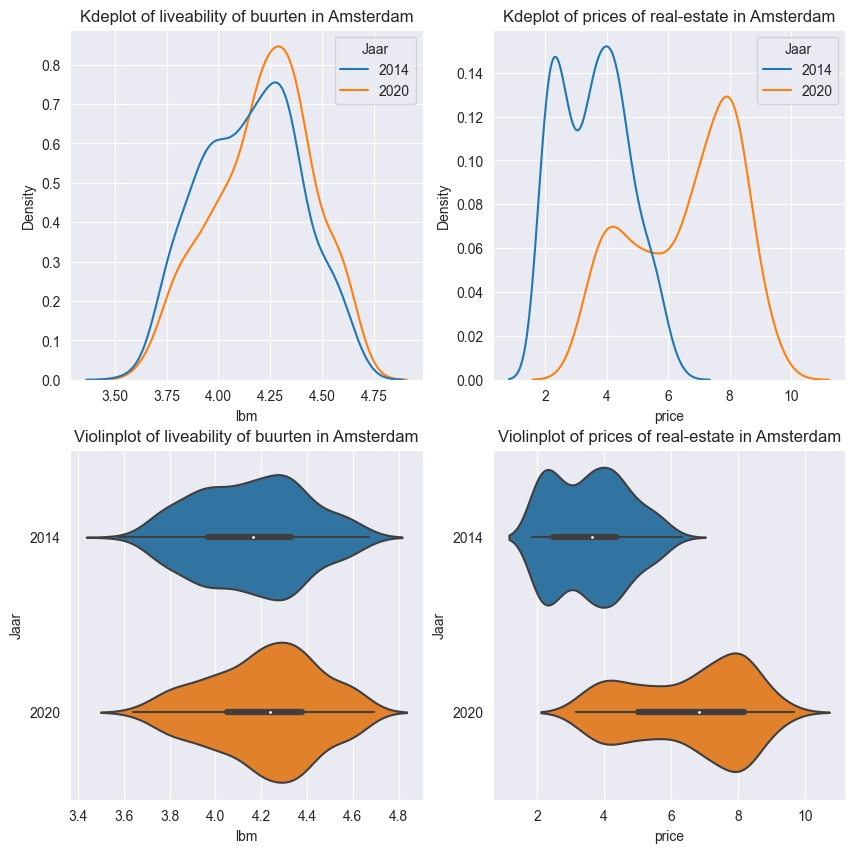

In [179]:
#Merge 2 datasets in 1 for easier plotting:
concatenated = pd.concat([df_2014.assign(dataset='df_2014'), df_2020.assign(dataset='df_2020')]).fillna(0).reset_index()
concatenated['price'] = concatenated.price_2014 + concatenated.price_2020
concatenated['jaar'] = concatenated['jaar'].astype(str)
concatenated.rename(columns={'jaar': "Jaar"}, inplace=True)
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

sns.kdeplot(data=concatenated, x="lbm", hue="Jaar", ax=ax[0][0])
sns.kdeplot(data=concatenated, x="price", hue="Jaar", ax=ax[0][1])
sns.violinplot(data=concatenated, x="lbm", y="Jaar", ax=ax[1][0])
sns.violinplot(data=concatenated, x="price", y="Jaar", ax=ax[1][1])

ax[0][0].set_title("Kdeplot of liveability of buurten in Amsterdam")
ax[0][1].set_title("Kdeplot of prices of real-estate in Amsterdam")
ax[1][0].set_title("Violinplot of liveability of buurten in Amsterdam")
ax[1][1].set_title("Violinplot of prices of real-estate in Amsterdam")

#### Interpretation of results
In general, liveability `lbm` has increased slightly over the years with a median of around 4.2 in 2020 in compared to 4.15 in 2014.  The real-estate prices have significantly increased and have almost doubled with house prices lying around 4 in 2014 whilst being around 7 in 2020. The prices also seem to follow a bimodal distribution since it has two peaks, the cheaper and the more expansive houses.

#### 2.2 Visualise the correlation between real-estate prices and liveability in Amsterdam, at the buurt level, with a scatter plot for each year. Then, visualise spatially real-estate prices and liveability in Amsterdam for 2014 and 2020 (use the same color scale for years 2014 and 2020).

Text(0.5, 1.0, 'Scatterplot of real-estate prices against liveability in 2020')

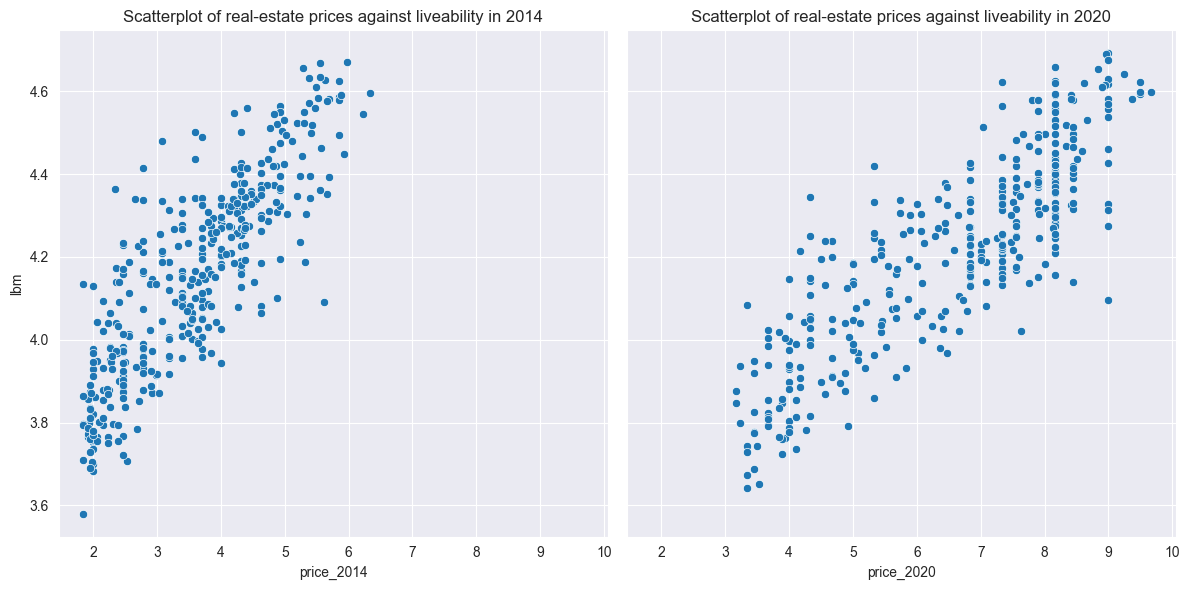

In [180]:
#Correlation of real-estate prices and liveability for each year
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharex=True, sharey=True)
fig.set_tight_layout(True)
sns.scatterplot(data=df_2014, x="price_2014", y="lbm", ax=ax[0])
sns.scatterplot(data=df_2020, x="price_2020", y="lbm", ax=ax[1])

ax[0].set_title("Scatterplot of real-estate prices against liveability in 2014")
ax[1].set_title("Scatterplot of real-estate prices against liveability in 2020")

#### Interpretation of results

An higher real-estate price seems to correlate with a better liveability which make sense. The correlation is more positive in 2014 when compared to 2020 as seen by the more vertical pattern of data in 2014. Furthermore, in 2014, a house with a price of around 6, could guarantee you a liveability of 4.6 which is quite high. Now in 2020, you would have to pay a price of 9 for the same liveability of 4.6 that you would get for a price of 6 in 2014.

 LBM Range: 3.5802410406032865 - 4.691523347613013
 price Range: 1.848 - 9.666666666666666


Text(0.5, 1.0, 'Real-estate prices of houses in Amsterdam in 2020')

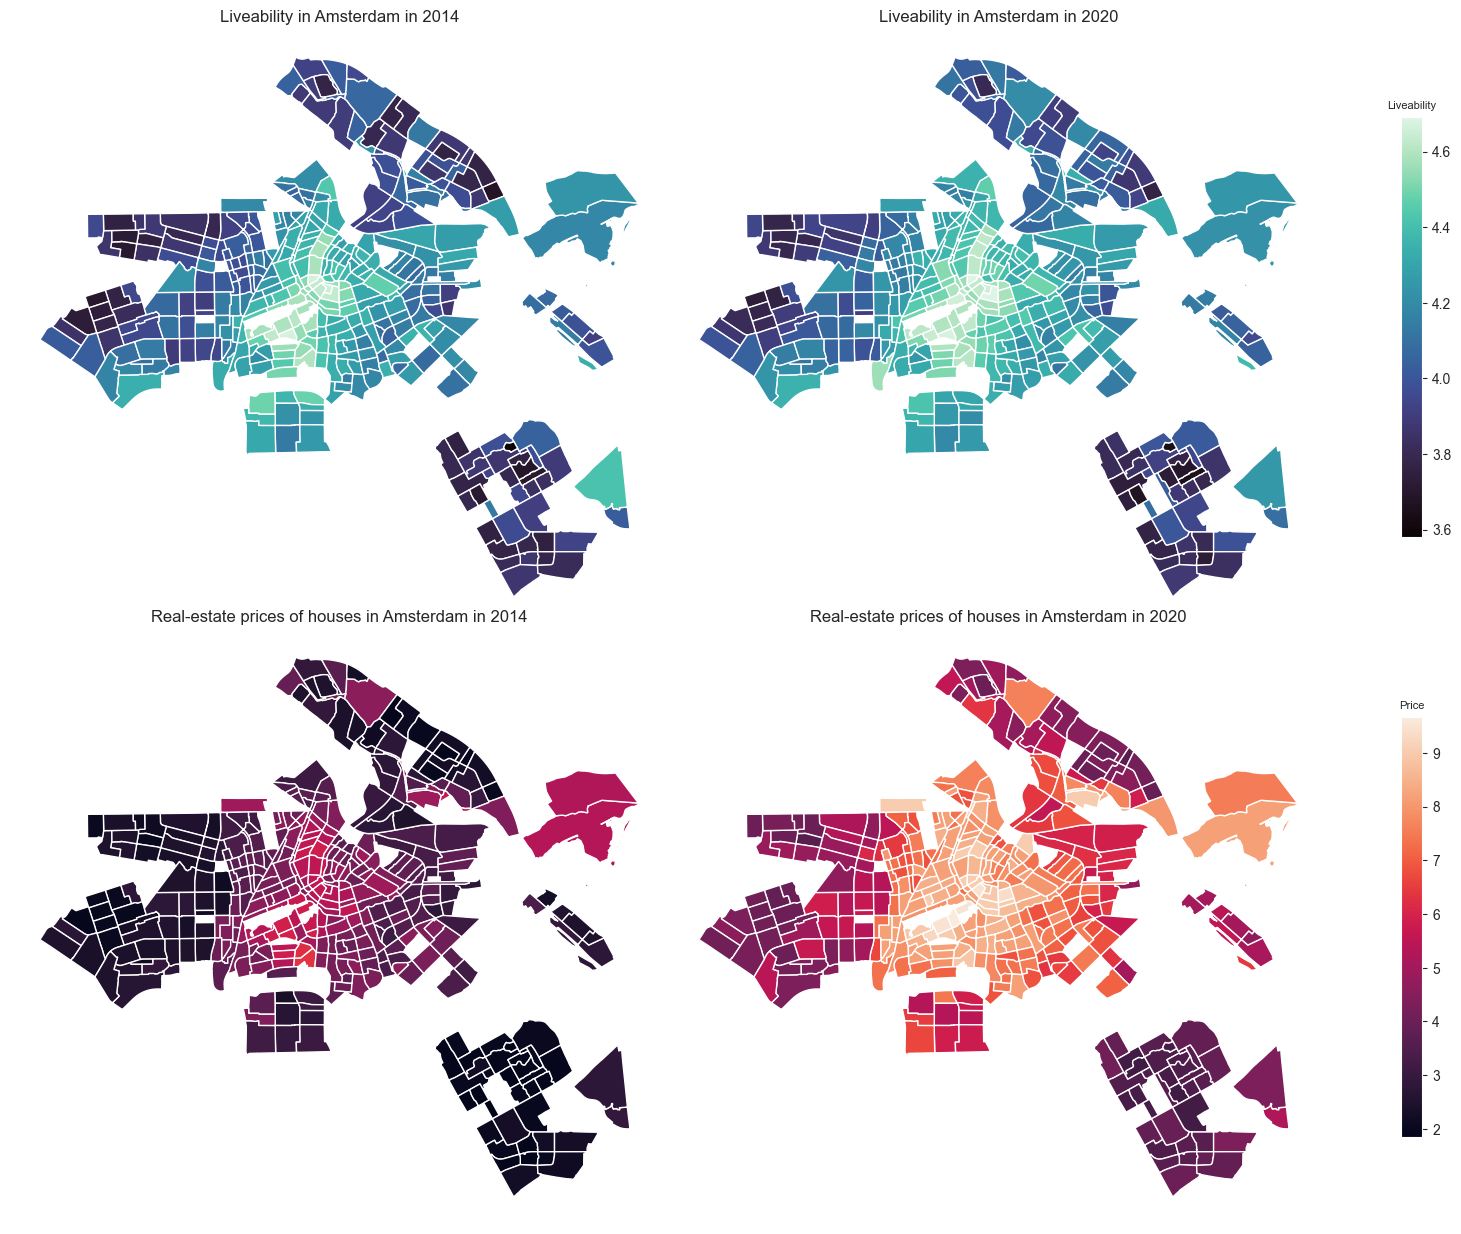

In [270]:
#Spatial visualisations
sns.color_palette("mako", as_cmap=True)

#Prepare min and max of colormapping
lbmMin = min(df_2014['lbm'].min(), df_2020['lbm'].min())
lbmMax = max(df_2014['lbm'].max(), df_2020['lbm'].max())
print(f" LBM Range: {lbmMin} - {lbmMax}")

priceMin = min(df_2014['price_2014'].min(), df_2020['price_2020'].min())
priceMax = max(df_2014['price_2014'].max(), df_2020['price_2020'].max())
print(f" price Range: {priceMin} - {priceMax}")

#Plot
fig, ax = plt.subplots(2, 2, figsize=(15,15),sharex=True, sharey=True, subplot_kw=dict(aspect='equal'))

fig.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0.0, hspace=0.4, bottom=0.1, top=0.9)
plt.subplots_adjust(hspace=0.0)
[axi.set_axis_off() for axi in ax.ravel()]

#Plots
df_2014.plot(ax=ax[0][0], column='lbm', cmap= 'mako', vmin=lbmMin, vmax = lbmMax)
df_2020.plot(ax=ax[0][1], column='lbm', cmap= 'mako', vmin=lbmMin, vmax = lbmMax)

df_2014.plot(ax=ax[1][0], column='price_2014', cmap='rocket', vmin=priceMin, vmax= priceMax)
df_2020.plot(ax=ax[1][1], column='price_2020',cmap='rocket', vmin=priceMin, vmax= priceMax)

#Add colorbars
patch_col = ax[0][0].collections[0]
cb1 = fig.colorbar(patch_col, ax=ax[0], shrink=0.7 , fraction=0.05)
cb1.ax.set_title('Liveability',fontsize=8)

patch_col = ax[1][0].collections[0]
cb2 = fig.colorbar(patch_col, ax=ax[1], shrink=0.7, fraction=0.05)
cb2.ax.set_title('Price',fontsize=8)

#Set titles
ax[0][0].set_title("Liveability in Amsterdam in 2014")
ax[0][1].set_title("Liveability in Amsterdam in 2020")
ax[1][0].set_title("Real-estate prices of houses in Amsterdam in 2014")
ax[1][1].set_title("Real-estate prices of houses in Amsterdam in 2020")





#### Interpretation of results

As seen in the spatial plots, the liveability increases generally a bit in the whole city (everything became a bit greener which indicates a higher `lbm`). In, the plots on the second row, we observe a massive increase in prices throughout whole Amsterdam from 2014 to 2020. Most expensive houses are in the centre in Amsterdam, and we can also see that those have a higher liveability.

### 3. Assess the change in affordability of liveable neighbourhoods [3 pnt]

#### 3.1 Explore how the change in liveability associates with a change in real-estate prices, using a scatter plot.

Text(0.5, 1.0, 'Scatterplot of liveability against real-estate prices in 2014 + 2020')

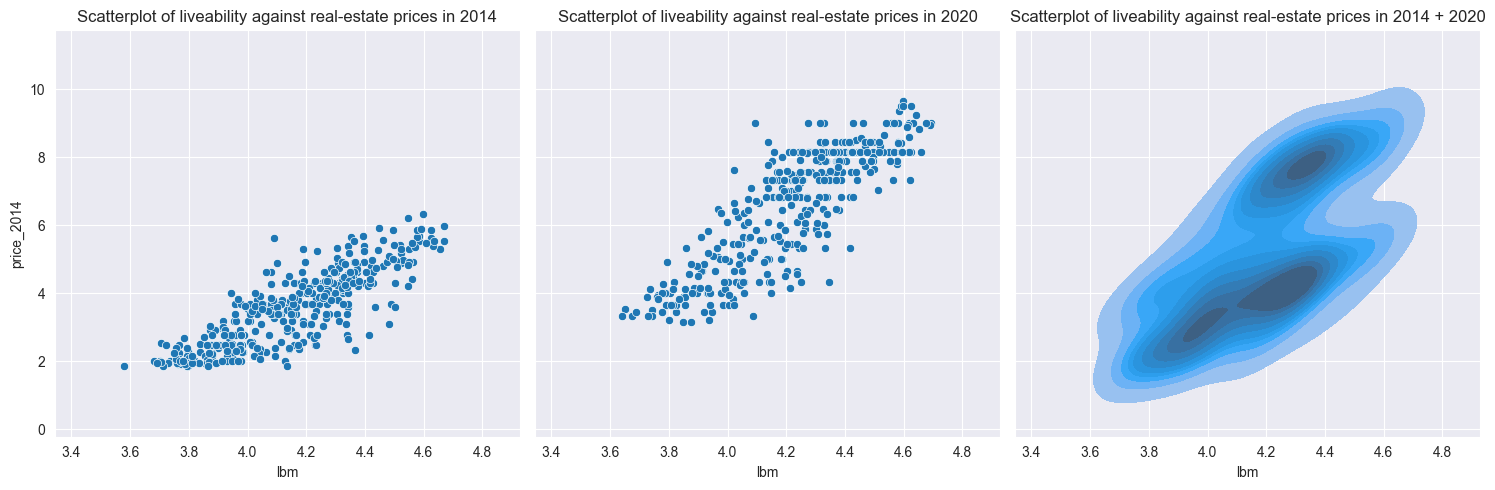

In [278]:
#Correlation of real-estate prices and liveability for each year
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharex=True, sharey=True)
fig.set_tight_layout(True)
sns.scatterplot(data=df_2014, y="price_2014", x="lbm", ax=ax[0])
sns.scatterplot(data=df_2020, y="price_2020", x="lbm", ax=ax[1])
sns.kdeplot(data=concatenated, y="price", x="lbm", ax=ax[2], fill=True)
ax[0].set_title("Scatterplot of liveability against real-estate prices in 2014")
ax[1].set_title("Scatterplot of liveability against real-estate prices in 2020")
ax[2].set_title("Kernel density plot of liveability against real-estate prices in 2014 + 2020")

#### Interpretation of results
In general, we can observe that a higher liveability corresponds with a higher neighbourhood average real-estate price. Over the years, this ratio seems to have increased. As an estimation, the general slope of a regression line fitted on both sets of data would be more vertical in 2020. So a change in liveability corresponds with a higher price increase in 2020 when compared to 2014.

#### 3.2 Compute the ratio of the liveability score over the real-estate price for both years, and show how the distribution of the ratio of liveability over real-estate price has changed between the two years.

In [279]:
#Calculate ratio of liveability over real estate price
df_2014['ratio'] = df_2014.lbm / df_2014.price_2014
df_2020['ratio'] = df_2020.lbm / df_2020.price_2020

df_2014.head()

,BU_CODE,gm_naam,geometry,versie,jaar,lbm,afw,fys,onv,soc,vrz,won,price_2014,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM,ratio
0,BU03630000,Amsterdam,"POLYGON ((121890.334 487818.898, 121957.841 48...",Leefbaarometer 3.0,2014,4.342111,0.239846,0.005343,-0.185291,-0.063916,0.483296,0.000414,3.594333,Kop Zeedijk,WK036300,GM0363,Amsterdam,18119,1100,625,470,4,11,52,25,7,36,18,0,1,2,1,12,773,4,96,79,20,78,7,71,96,4,21,20,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2,1.208044
1,BU03630001,Amsterdam,"POLYGON ((121585.791 487654.680, 121624.240 48...",Leefbaarometer 3.0,2014,4.313165,0.210901,0.004292,-0.241124,-0.064267,0.507547,0.004453,4.313000,Oude Kerk e.o.,WK036300,GM0363,Amsterdam,8272,730,410,315,4,18,51,18,9,34,17,1,1,2,1,13,534,5,95,78,12,85,27,59,87,13,22,20,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2,1.000038
2,BU03630002,Amsterdam,"POLYGON ((121799.802 487534.283, 121824.012 48...",Leefbaarometer 3.0,2014,4.275189,0.172924,0.002242,-0.235697,-0.087144,0.498839,-0.005316,3.851000,Burgwallen Oost,WK036300,GM0363,Amsterdam,25867,1610,855,755,5,16,48,19,11,34,20,1,1,2,1,15,1001,4,96,85,17,82,9,74,96,4,15,40,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2,1.110150
3,BU03630003,Amsterdam,"POLYGON ((121345.067 487317.970, 121365.571 48...",Leefbaarometer 3.0,2014,4.418488,0.316223,0.037115,-0.217396,-0.041720,0.538209,0.000016,4.867400,Nes e.o.,WK036300,GM0363,Amsterdam,6565,350,195,155,5,17,51,20,7,38,12,0,0,1,2,8,263,9,91,71,29,70,5,65,98,2,29,10,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2,0.907772
4,BU03630004,Amsterdam,"POLYGON ((121557.295 487212.269, 121595.682 48...",Leefbaarometer 3.0,2014,4.420118,0.317854,0.014476,-0.187590,-0.056868,0.527690,0.020145,4.813500,BG-terrein e.o.,WK036300,GM0363,Amsterdam,7960,670,370,300,5,19,43,22,12,28,14,1,1,2,1,9,400,7,93,85,21,78,36,42,100,0,15,10,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3,0.918275


Text(0.5, 1.0, 'Violinplot of lbm / price ratio in Amsterdam')

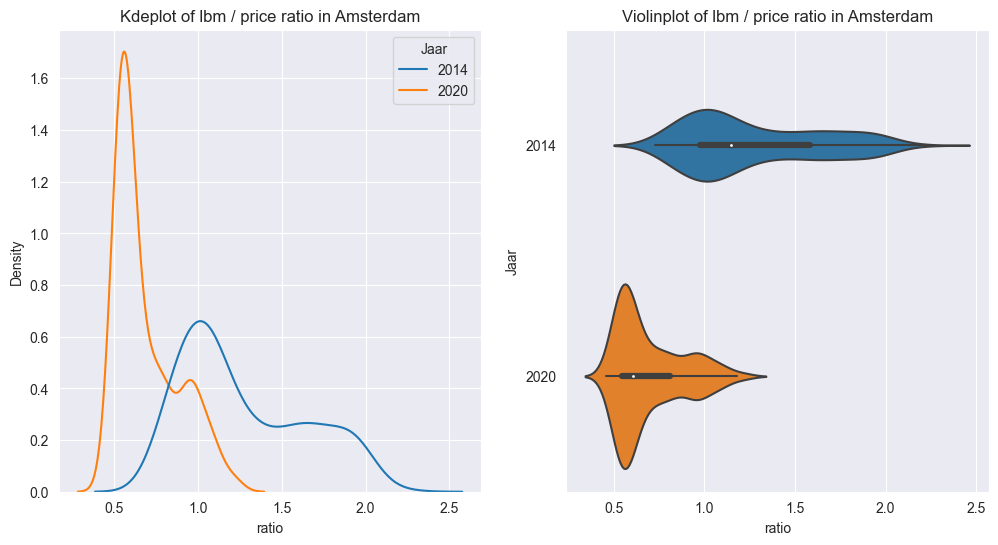

In [283]:
#Update concatenated
concatenated = pd.concat([df_2014.assign(dataset='df_2014'), df_2020.assign(dataset='df_2020')]).fillna(0).reset_index()
concatenated['price'] = concatenated.price_2014 + concatenated.price_2020
concatenated['jaar'] = concatenated['jaar'].astype(str)
concatenated.rename(columns={'jaar': "Jaar"}, inplace=True)

#Show distribution plots
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

sns.kdeplot(data=concatenated, x="ratio", hue="Jaar", ax=ax[0])
sns.violinplot(data=concatenated, x="ratio", y="Jaar", ax=ax[1])

ax[0].set_title("Kdeplot of lbm / price ratio in Amsterdam")
ax[1].set_title("Violinplot of lbm / price ratio in Amsterdam")

#### Interpretation of results

From the results we can observe that this ratio has severly decreased over the years with a median ratio of around 0.6 in 2020 and 1.2 in 2014. So we can estimate on average that a person would get half the liveability for the same real-estate price in 2020 when compared to 2014. Both are bimodal distributions with one larger peak, and the distribution of ratio in 2020 has less variance than 2014.

#### 3.3 Determine the 5 buurten in which the ratio of liveability over real-estate has deteriorated most.

In [330]:
#Merge both 2014 and 2020 on ratio
df_joined = pd.merge(df_2014[['BU_CODE', 'ratio']], df_2020[['BU_CODE', 'ratio']], how='inner', on='BU_CODE')
assert len(df_joined) == min(len(df_2014), len(df_2020))

#Calculate diff
df_joined['ratio_diff'] = df_joined.ratio_x - df_joined.ratio_y
df_joined.sort_values(by='ratio_diff', inplace=True, ascending=False)
df_joined.head()

,BU_CODE,ratio_x,ratio_y,ratio_diff
101,BU03632303,1.864486,0.575922,1.288564
317,BU03638604,1.823374,0.689720,1.133653
279,BU03637402,2.062419,0.932216,1.130203
271,BU03637002,1.959852,0.837455,1.122397
315,BU03638602,1.864883,0.795698,1.069185


In [318]:
#Take 5 largest ratio_diff
df_2020_ratio = pd.merge(df_2020, df_joined[['BU_CODE', 'ratio_diff']], how='left', on='BU_CODE')
buurt_codes = df_2020_ratio.nlargest(5, columns=["ratio_diff"])[['BU_CODE', 'BU_NAAM', 'ratio_diff']]
buurt_codes.head()

,BU_CODE,BU_NAAM,ratio_diff
101,BU03632303,Zuidas Zuid,1.288564
317,BU03638604,Johan Jongkindbuurt,1.133653
279,BU03637402,Elzenhagen Noord,1.130203
271,BU03637002,Banne Noordwest,1.122397
315,BU03638602,Rembrandtpark Noord,1.069185



#### 3.4 Determine whether the number of buurten with price < 5k euro/m2 and a liveability ratio > 1/k euro has decreased in 2020, compared to 2014

In [343]:
df_2014_filter = df_2014[(df_2014.price_2014 < 5) & (df_2014.ratio > 1)]
df_2020_filter = df_2020[(df_2020.price_2020 < 5) & (df_2020.ratio > 1)]

if len(df_2020_filter) < len(df_2014_filter):
    print(f"Yes, the number of buurten with price < 5 and ratio > 1 has decreased from {len(df_2014_filter)} buurten in 2014 to"
          f" {len(df_2020_filter)} buurten in 2020.")
else:
    print(f"No, the number of buurten with price < 5 and ratio > 1 has not decreased in 2020 compared to 2014.")


Yes, the number of buurten with price < 5 and ratio > 1 has decreased from 272 buurten in 2014 to 34 buurten in 2020.


### 4. Qualitative reflection on machine learning and generalisation [1 pnt]

Qualitative reflection on machine learning and generalisation: There are some buurts in Amsterdam for which real-estate price data were missing. Suppose the minicipality of Amsterdam asks you whether you can create a machine learning model that can predict real-estate prices from the liveability index. Do you think this is possible? Explain your answer (conceptually). [1 pnt]

In [348]:
buurten_amsterdam = buurt_pop_data[buurt_pop_data.GM_NAAM == 'Amsterdam']
buurten_real_estate = min(len(df_2020), len(df_2014))
print(f"As we can see, there are in total {len(buurten_amsterdam)} buurten in Amsterdam, and we only have real-estate data of {buurten_real_estate} buurten.")

As we can see, there are in total 479 buurten in Amsterdam, and we only have real-estate data of 378 buurten.


#### Is it possible to predict real-estate prices from liveability?

No, I don't this is possible, due to the following factors.
Firstly, it will not return very accurate results since we are only looking at the liveability index. When looking at the scatterplots of correlation between `lbm` and `price`, we still observe a high variance in price given a certain `lbm` value even if we would obtain the best regression model with the lowest error. Furthermore, we would need more training / test data since only +- 380 data points with a ground truth will not be enough to train a model. Also the model would perform better if we would add more important features next to the liveability index that have high correlation and impact to the real-estate price variable to predict it more accurately.

I think a nice solution for the missing real-estate data of buurten would be by taking the average price of neighbouring buurten (if we know the the price of at least 3 neighbours, else leave them out).